## **Our model and plan**

We are using a Convolution Neural Network (CNN) autoencoder, which expects square or image-like shaped input. But your studies have:

| **Study** | **Autoantibodies Count** |
| :- | :-: |
| SDY797 | 5 |
| SDY524 | 4 |
| SDY569 | 3 |
| SDY1625 | 3 |
| SDY1737 | 4 |

## CNNs require fixed-sized 2D+channel inputs

CNN'S require fixed-sized 2D+channel inputs (e.g. 2×2×1), so we must standardize shape per dataset.

We standarize the shape of the antibodies via padding, adding an additional column, null column,
ensuring each study can be compared via federated learning

### **Reshape Input for CNN**

| Study     | # Antibodies | Padding Needed? | Final Shape (for CNN) |
| :-------- | :----------: | :------------ | :---------------------: |
| tidy_797  | 5            | No            | `(N, 5, 1, 1)`          |
| tidy_524  | 4            | Yes (pad 1)   | `(N, 5, 1, 1)`          |
| tidy_1737 | 4            | Yes (pad 1)   | `(N, 5, 1, 1)`          |
| tidy_1625 | 3            | Yes (pad 2)   | `(N, 5, 1, 1)`          |
| tidy_569  | 3            | Yes (pad 2)   | `(N, 5, 1, 1)`          |


### **Plan for Analysis**

* **train_and_evaluate_cnn_autoencoder** function scales, pads, autoencodes, trains, tests and evaluates to 5 features
* In the analysis steps, we perform z-score normalization on the autoantibodies in the study (before calling *prepare_autoantibody_data*.
* We split each study data into train/test
* We reshapes into (samples, 5, 1, 1) for convolution neural network (CNN) in the function *prepare_autoantibody_data*
* We train a simple 1D CNN autoencoder
* We evaluate our intra-study results via mean square error (MSE) on test
* We visualize our ability to reconstruct using the separate study models (with autoantibody labels)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
def train_and_evaluate_cnn_autoencoder(csv_path, study_name, max_features=5, epochs=50):
    print(f"\n===== Training CNN Autoencoder for {study_name} =====")
    
    # === Load CSV
    df = pd.read_csv(csv_path)

    # === Normalize antibody column names
    df["Property"] = df["Property"].str.upper().str.replace(r"[^A-Z0-9]", "", regex=True)

    # === Pivot to wide format
    df_wide = df.pivot(index="Accession", columns="Property", values="Value")
    df_wide = df_wide.sort_index(axis=1)
    df_wide = df_wide.fillna(0)

    antibody_labels = df_wide.columns.tolist()
    print(f"Detected {len(antibody_labels)} antibodies:", antibody_labels)

    # === Convert to array and pad if needed
    X = df_wide.values
    if X.shape[1] < max_features:
        pad_width = max_features - X.shape[1]
        X = np.pad(X, ((0, 0), (0, pad_width)), mode='constant')
        antibody_labels += [f"PAD_{i}" for i in range(pad_width)]

    # === Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # === Split
    X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

    # === Reshape for CNN
    X_train_reshaped = X_train.reshape(-1, max_features, 1, 1)
    X_test_reshaped = X_test.reshape(-1, max_features, 1, 1)

    # === CNN Autoencoder
    input_layer = layers.Input(shape=(max_features, 1, 1))
    x = layers.Conv2D(4, (3, 1), activation='relu', padding='same')(input_layer)
    x = layers.Flatten()(x)
    encoded = layers.Dense(2, activation='relu')(x)
    x = layers.Dense(max_features * 1 * 4, activation='relu')(encoded)
    x = layers.Reshape((max_features, 1, 4))(x)
    decoded = layers.Conv2D(1, (3, 1), activation='linear', padding='same')(x)

    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # === Train
    history = autoencoder.fit(
        X_train_reshaped, X_train_reshaped,
        epochs=epochs,
        batch_size=8,
        validation_data=(X_test_reshaped, X_test_reshaped),
        verbose=0
    )

    # === Predict and Flatten
    reconstructed = autoencoder.predict(X_test_reshaped)
    reconstructed_flat = reconstructed.reshape(X_test.shape)

    # === Save
    autoencoder.save(f"{study_name}_autoencoder.keras")
    autoencoder.save_weights(f"{study_name}.weights.h5")
    print(" Model saved.")

    # === Plot loss
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title(f"{study_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # === Plot reconstruction comparison
    for i in range(min(5, X_test.shape[0])):
        plt.figure(figsize=(6, 3))
        indices = np.arange(len(antibody_labels))
        plt.bar(indices, X_test[i], width=0.35, label='Original', alpha=0.6)
        plt.bar(indices + 0.35, reconstructed_flat[i], width=0.35, label='Reconstructed', alpha=0.6)
        plt.xticks(indices + 0.35 / 2, antibody_labels, rotation=45)
        plt.title(f"{study_name} Sample {i}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # === Evaluate
    mse = mean_squared_error(X_test, reconstructed_flat)
    print(f"📉 Final MSE on {study_name}: {mse:.4f}")




===== Training CNN Autoencoder for sdy797 =====
Detected 5 antibodies: ['GAD65', 'IA2IC', 'ICA', 'MIAA', 'ZNT8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Model saved.


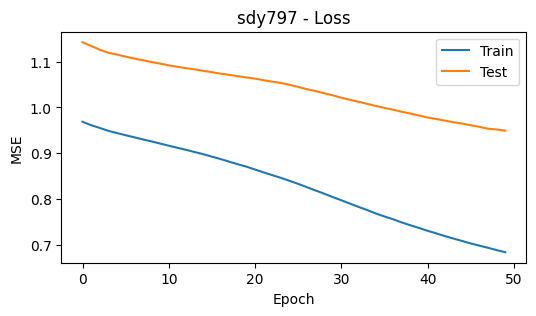

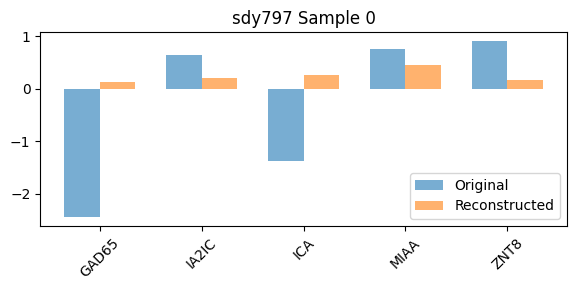

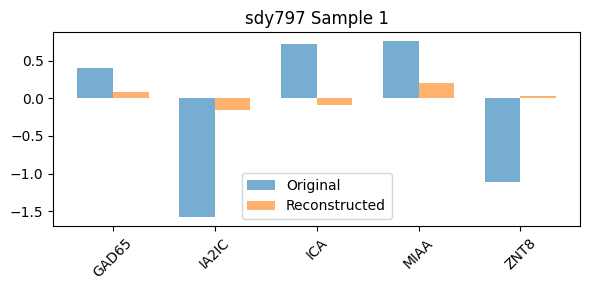

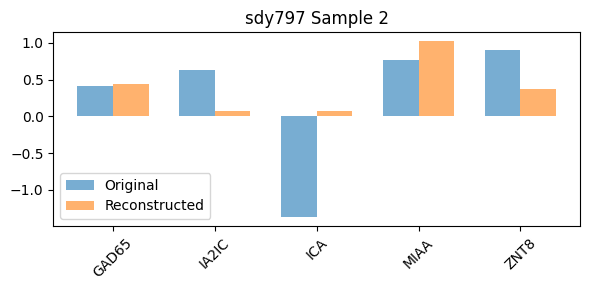

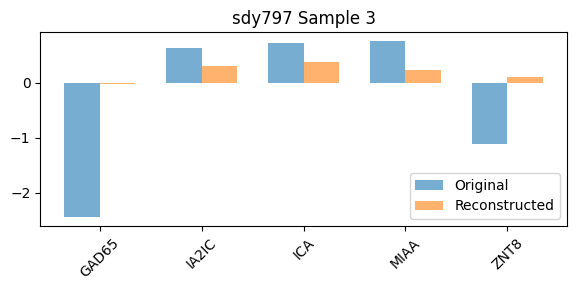

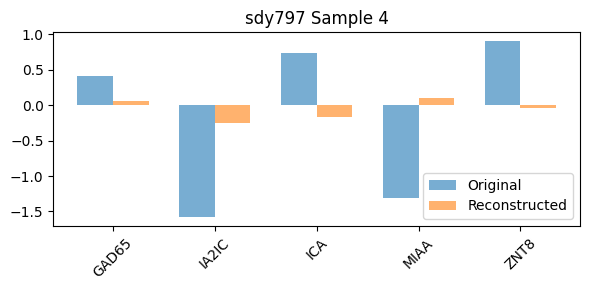

📉 Final MSE on sdy797: 0.9493

===== Training CNN Autoencoder for sdy524 =====
Detected 4 antibodies: ['GAD65', 'IA2IC', 'MIAA', 'ZNT8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Model saved.


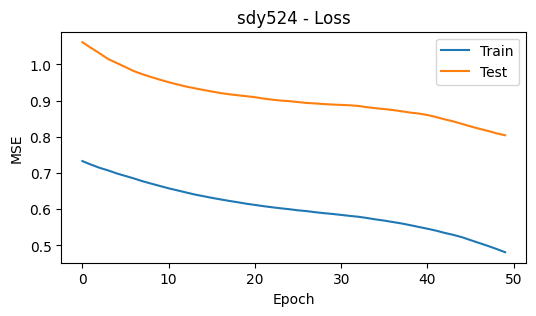

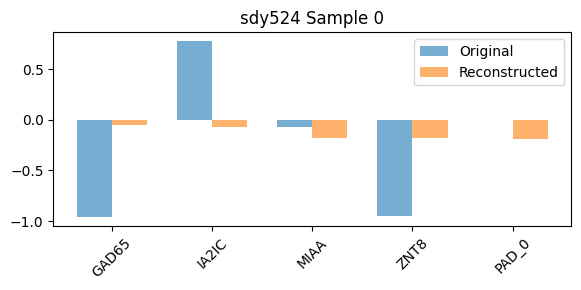

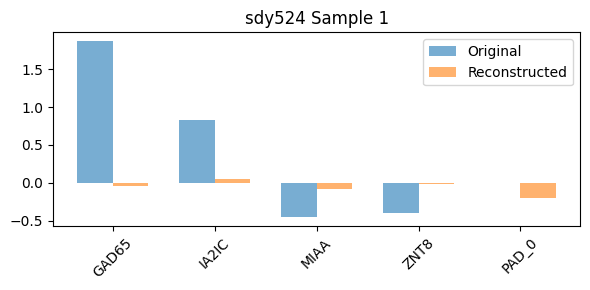

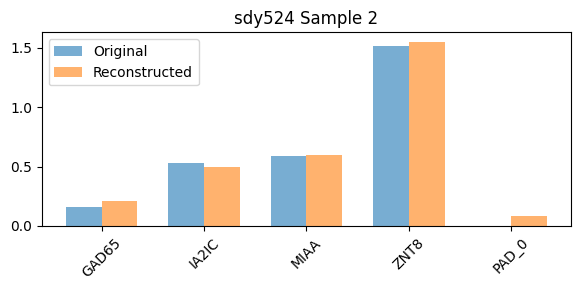

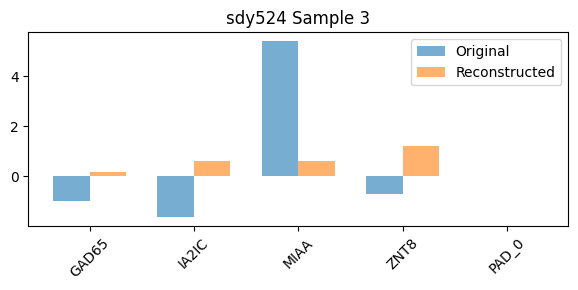

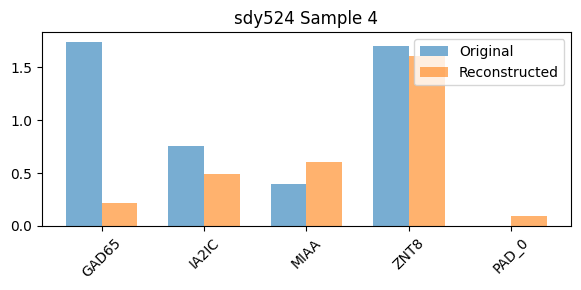

📉 Final MSE on sdy524: 0.8043

===== Training CNN Autoencoder for sdy569 =====
Detected 3 antibodies: ['GAD65', 'IA2IC', 'MIAA']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Model saved.


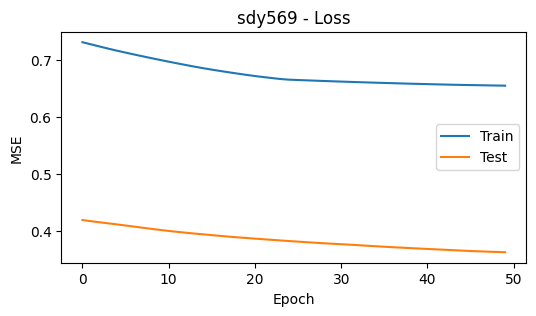

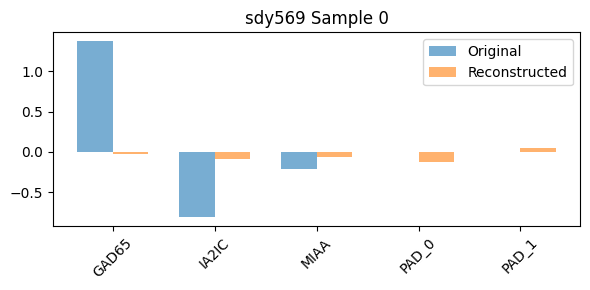

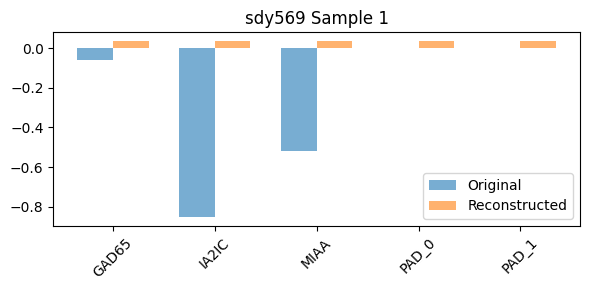

📉 Final MSE on sdy569: 0.3624

===== Training CNN Autoencoder for sdy1625 =====
Detected 3 antibodies: ['GAD65', 'IA2IC', 'ZNT8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Model saved.


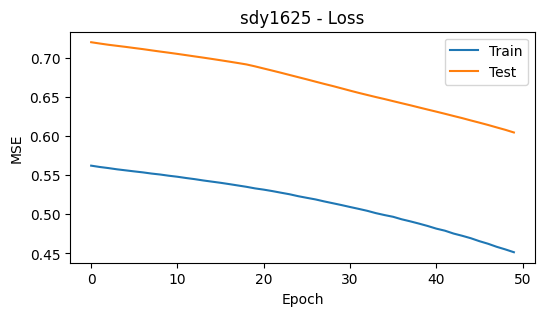

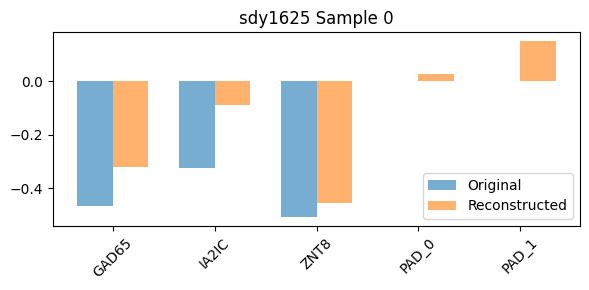

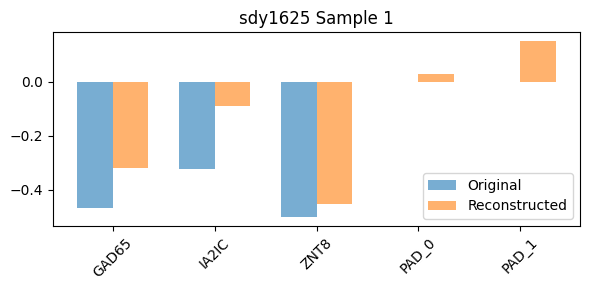

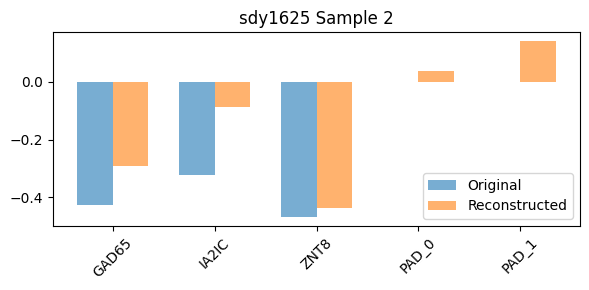

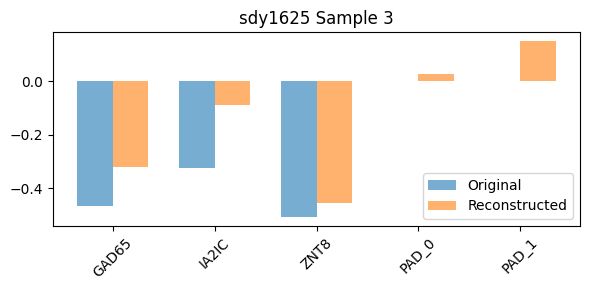

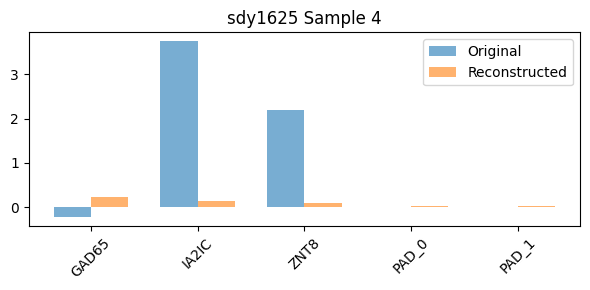

📉 Final MSE on sdy1625: 0.6045

===== Training CNN Autoencoder for sdy1737 =====
Detected 4 antibodies: ['GAD65', 'IA2IC', 'MIAA', 'ZNT8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Model saved.


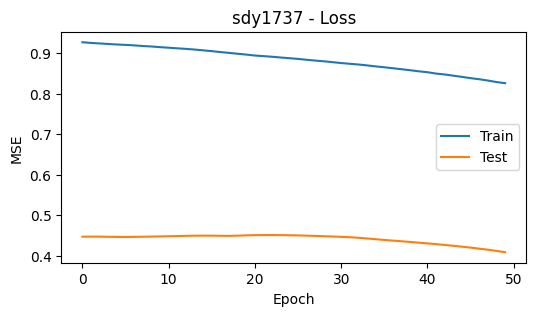

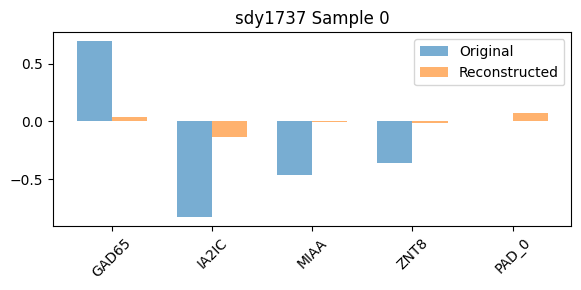

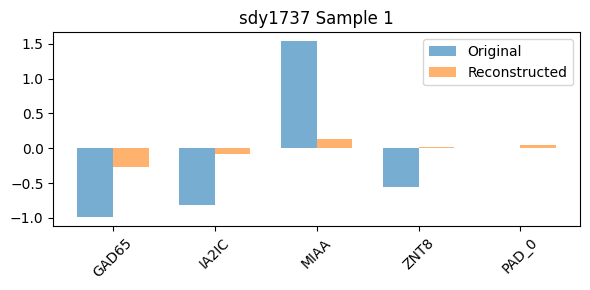

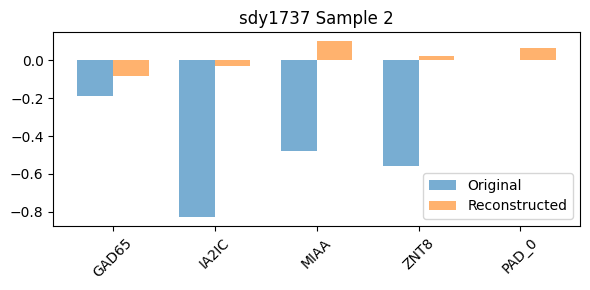

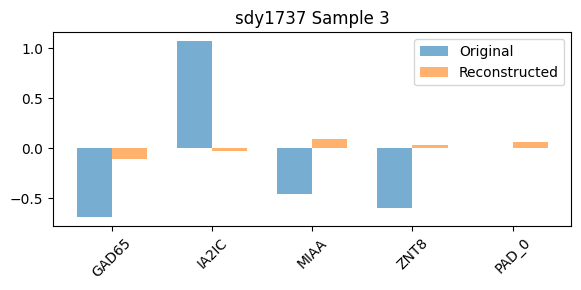

📉 Final MSE on sdy1737: 0.4082


In [3]:
train_and_evaluate_cnn_autoencoder("data/tidy_797.csv", "sdy797")
train_and_evaluate_cnn_autoencoder("data/tidy_524.csv", "sdy524")
train_and_evaluate_cnn_autoencoder("data/tidy_569.csv", "sdy569")
train_and_evaluate_cnn_autoencoder("data/tidy_1625.csv", "sdy1625")
train_and_evaluate_cnn_autoencoder("data/tidy_1737.csv", "sdy1737")